In [1]:
import pandas as pd


def clean_queries(series):
    cleaned = series.str.replace(
        r'\s+\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\s*|\n',
        ' ',
        regex=True
    ).str.replace(r'\s+', ' ', regex=True).str.strip()
    
    return cleaned

df = pd.read_csv('sample_data.txt',
                 sep='\0',
                 header=0,
                 names=['value'],
                 engine='c',
                 dtype=str,
                 na_filter=False)

df['query'] = clean_queries(df['value'])
df = df.drop('value', axis=1)

df = df[df['query'] != ''].copy()
df.head(10), df.size

(                                               query
 0                                            datakam
 1                            yuxuda kız usagi gormek
 2                                              порно
 3                                         цефотаксим
 4  вертикальном цилиндрическом сосуде над поршнем...
 5  панель управления стиральной машины самсунг эк...
 6                           полки авито екатеринбург
 7              зарплата санитарки в больнице боткина
 8                  аптека в кубинке торговля травами
 9                                          wapsky ru,
 39789519)

In [2]:
# # Построение графа совстречаемости (co-occurrence) через pandas/numpy (+ sparse матрицы)
# # Идея: строим term-document матрицу X (запросы × слова), затем C = X.T @ X даёт число запросов,
# # где слова встретились вместе. После этого считаем веса NPMI/PPMI и формируем граф.

# import numpy as np
# import pandas as pd
# import networkx as nx
# import scipy.sparse as sp
# import nltk
# import re

# from collections import Counter, defaultdict
# from nltk.corpus import stopwords
# from nltk.stem.snowball import EnglishStemmer, RussianStemmer


# # --- Stopwords / stemming (EN + RU) ---
# try:
#     _ = stopwords.words("english")
#     _ = stopwords.words("russian")
# except LookupError:
#     nltk.download("stopwords")

# STOP_EN = set(stopwords.words("english"))
# STOP_RU = set(stopwords.words("russian"))
# STEM_EN = EnglishStemmer()
# STEM_RU = RussianStemmer()


# def is_cyrillic(token: str) -> bool:
#     return bool(re.search(r'[а-яёА-ЯЁ]', token))


# def normalize_token(token: str) -> str:
#     # Нормализация: стемминг (быстро). При желании можно заменить на лемматизацию.
#     if is_cyrillic(token):
#         return STEM_RU.stem(token)
#     return STEM_EN.stem(token)


# def tokenize_query(text: str, *, min_token_len: int = 2) -> list[str]:
#     """Токенизирует один запрос в список нормализованных токенов.

#     Важно: запрос целиком = один контекст.
#     """
#     tokens = [t.lower() for t in re.findall(r'[a-zA-Zа-яёА-ЯЁ]+', str(text))]
#     out: list[str] = []
#     for t in tokens:
#         if len(t) < min_token_len:
#             continue
#         if is_cyrillic(t):
#             if t in STOP_RU:
#                 continue
#         else:
#             if t in STOP_EN:
#                 continue
#         out.append(normalize_token(t))
#     return out


# def _build_cooccurrence_full_context(
#     tokenized_texts: list[list[str]],
#     term_to_idx: dict[str, int],
#     V: int,
# ) -> sp.csr_matrix:
#     """Строит матрицу совстречаемости: весь документ = один контекст."""
    
#     row_indices = []
#     col_indices = []
    
#     for doc_id, tokens in enumerate(tokenized_texts):
#         seen = set()
#         for t in tokens:
#             if t in term_to_idx and t not in seen:
#                 row_indices.append(doc_id)
#                 col_indices.append(term_to_idx[t])
#                 seen.add(t)
    
#     data = np.ones(len(row_indices), dtype=np.int32)
#     X = sp.csr_matrix(
#         (data, (row_indices, col_indices)),
#         shape=(len(tokenized_texts), V),
#         dtype=np.int32
#     )
    
#     # C = X.T @ X
#     C = (X.T @ X).tocsr().astype(np.int64)
#     C.setdiag(0)
#     C.eliminate_zeros()
    
#     return C


# def _build_cooccurrence_window(
#     tokenized_texts: list[list[str]],
#     term_to_idx: dict[str, int],
#     V: int,
#     window_size: int,
# ) -> sp.csr_matrix:
#     """Строит матрицу совстречаемости с sliding window.
    
#     Для каждой пары слов (i, j) в пределах окна увеличиваем C[i,j] на 1.
#     """
#     pair_counts = defaultdict(int)
    
#     for tokens in tokenized_texts:
#         # Фильтруем только слова из словаря
#         filtered = [(i, term_to_idx[t]) for i, t in enumerate(tokens) if t in term_to_idx]
        
#         # Sliding window: для каждого слова смотрим на слова в пределах окна
#         for i, (pos_i, idx_i) in enumerate(filtered):
#             for pos_j, idx_j in filtered[i + 1:]:
#                 # Проверяем, что слова в пределах окна (по позиции в оригинальном тексте)
#                 if pos_j - pos_i <= window_size:
#                     # Сортируем индексы для симметричной матрицы
#                     pair = (min(idx_i, idx_j), max(idx_i, idx_j))
#                     pair_counts[pair] += 1
#                 else:
#                     break
    
#     if not pair_counts:
#         return sp.csr_matrix((V, V), dtype=np.int64)
    
#     rows, cols, data = [], [], []
#     for (i, j), count in pair_counts.items():
#         rows.append(i)
#         cols.append(j)
#         data.append(count)
#         # Симметрично
#         rows.append(j)
#         cols.append(i)
#         data.append(count)
    
#     C = sp.csr_matrix(
#         (data, (rows, cols)),
#         shape=(V, V),
#         dtype=np.int64
#     )
    
#     return C


# def build_cooccurrence_edges_df(
#     texts: list[str],
#     *,
#     min_df: int = 5,
#     max_df_ratio: float = 0.2,
#     min_pair_count: int = 5,
#     min_weight: float = 0.0,
#     window_size: int | None = None,  # NEW: размер окна (None = весь запрос)
#     verbose: bool = True,
# ) -> tuple[pd.DataFrame, np.ndarray, sp.csr_matrix, np.ndarray]:
#     """Строит таблицу рёбер графа совстречаемости.

#     Параметры:
#     - window_size: размер sliding window для подсчёта совстречаемости.
#       - None (default): весь запрос = один контекст (слова встречаются вместе, если в одном запросе)
#       - int > 0: слова встречаются вместе, если расстояние между ними <= window_size
#         Например, window_size=2: "a b c d" -> пары (a,b), (a,c), (b,c), (b,d), (c,d)

#     Возвращает:
#     - edges_df: pandas.DataFrame со столбцами [src, dst, count, weight]
#     - terms: np.ndarray[str] — словарь (индекс -> токен)
#     - C: sparse csr (terms x terms) — матрица совместной встречаемости
#     - df: np.ndarray[int] — document frequency каждого слова
#     """

#     if len(texts) == 0:
#         raise ValueError("texts пустой")

#     # 1) Токенизируем все тексты
#     tokenized_texts = [tokenize_query(t) for t in texts]
    
#     # 2) Строим словарь с фильтрацией по df
#     doc_freq = Counter()
#     for tokens in tokenized_texts:
#         doc_freq.update(set(tokens))
    
#     N = len(texts)
#     max_df_abs = int(max_df_ratio * N) if isinstance(max_df_ratio, float) else max_df_ratio
    
#     # Фильтруем словарь
#     valid_terms = {
#         term for term, freq in doc_freq.items()
#         if min_df <= freq <= max_df_abs
#     }
    
#     # Создаём отображение term -> index
#     terms = np.array(sorted(valid_terms))
#     term_to_idx = {t: i for i, t in enumerate(terms)}
#     V = len(terms)
    
#     if verbose:
#         print(f"Queries (N): {N:,}")
#         print(f"Vocab size (after min_df/max_df): {V:,}")
#         if window_size:
#             print(f"Window size: {window_size}")
    
#     if V == 0:
#         edges_df = pd.DataFrame(columns=["src", "dst", "count", "weight"])
#         return edges_df, terms, sp.csr_matrix((0, 0)), np.array([])
    
#     # 3) Строим матрицу совстречаемости
#     if window_size is None:
#         C = _build_cooccurrence_full_context(tokenized_texts, term_to_idx, V)
#     else:
#         C = _build_cooccurrence_window(tokenized_texts, term_to_idx, V, window_size)
    
#     # document frequency для PMI
#     df = np.array([doc_freq.get(t, 0) for t in terms], dtype=np.int64)
    
#     if verbose:
#         print(f"C nnz (before filtering): {C.nnz:,}")
    
#     # 4) Фильтр по частоте пары
#     if min_pair_count > 1:
#         C = C.multiply(C >= min_pair_count).tocsr()
#         C.eliminate_zeros()
    
#     # 5) Берём только верхний треугольник
#     Cu = sp.triu(C, k=1).tocoo()
    
#     if verbose:
#         print(f"Cu nnz (upper triangle): {Cu.nnz:,}")

#     rows = Cu.row
#     cols = Cu.col
#     counts = Cu.data.astype(np.int64)

#     if counts.size == 0:
#         edges_df = pd.DataFrame(columns=["src", "dst", "count", "weight"])
#         return edges_df, terms, C, df

#     # 6) Считаем NPMI веса
#     denom = (df[rows] * df[cols]).astype(np.float64)
#     num = counts.astype(np.float64) * float(N)

#     denom = np.maximum(denom, 1.0)
#     pmi = np.log(num / denom)

#     norm = np.log(float(N) / counts.astype(np.float64))
#     norm = np.maximum(norm, 1e-12)
#     w = pmi / norm

#     # 7) Фильтр по весу
#     keep = w >= float(min_weight)
#     rows = rows[keep]
#     cols = cols[keep]
#     counts = counts[keep]
#     w = w[keep]

#     edges_df = pd.DataFrame({
#         "src": terms[rows],
#         "dst": terms[cols],
#         "count": counts,
#         "weight": w,
#     }).sort_values(["weight", "count"], ascending=[False, False], ignore_index=True)

#     if verbose:
#         print(f"Edges kept: {len(edges_df):,}")

#     return edges_df, terms, C, df


# # ---- Запуск на вашем df ----
# texts = df["query"].astype(str).tolist()

# edges_df, terms, C, df_counts = build_cooccurrence_edges_df(
#     texts,
#     min_df=100,
#     max_df_ratio=0.2,
#     min_pair_count=1000,
#     min_weight=0.1,
#     window_size=3,
#     verbose=True,
# )

# # networkx граф (по желанию)
# G = nx.from_pandas_edgelist(edges_df, source="src", target="dst", edge_attr=["weight", "count"])
# print(f"Graph: |V|={G.number_of_nodes():,}, |E|={G.number_of_edges():,}")

# # Быстрая диагностика: топ-слова по суммарному весу инцидентных рёбер
# node_strength = {n: 0.0 for n in G.nodes()}
# for u, v, d in G.edges(data=True):
#     w = float(d.get("weight", 0.0))
#     node_strength[u] += w
#     node_strength[v] += w

# pd.Series(node_strength).sort_values(ascending=False).head(20)

In [3]:
# Построение графа совстречаемости — БЫСТРАЯ ВЕРСИЯ (исправленная)
# Оптимизации: vectorized pandas, быстрый regex-based стемминг

import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import re
import time

from collections import Counter


# ============== СТОП-СЛОВА ==============

STOP_EN = frozenset([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her',
    'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs',
    'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those',
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with',
    'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where',
    'why', 'how', 'all', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
    't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're',
    've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven',
    'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren',
    'won', 'wouldn'
])

STOP_RU = frozenset([
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то',
    'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за',
    'бы', 'по', 'только', 'её', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще',
    'ещё', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг',
    'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь',
    'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может',
    'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем',
    'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под',
    'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой',
    'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы',
    'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при',
    'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот',
    'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве',
    'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда',
    'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно',
])

STOP_ALL = STOP_EN | STOP_RU


# ============== БЫСТРЫЙ СТЕММИНГ ==============

# Английские окончания (Porter-like, упрощённый)
EN_SUFFIX_PATTERN = re.compile(
    r"(ational|tional|enci|anci|izer|ation|ator|alism|iveness|fulness|ousness|"
    r"aliti|iviti|biliti|alli|entli|eli|ousli|ization|ication|ness|ment|"
    r"able|ible|ance|ence|er|ic|ful|less|ive|ous|ing|ed|es|ly|s)$"
)

# Русские окончания
RU_SUFFIX_PATTERN = re.compile(
    r"(ость|ност|ств|ени|ани|ова|ева|ыва|ива|"
    r"ющ|ащ|вш|ем|нн|ют|ят|ет|ит|им|ым|ой|ий|ый|ая|яя|ое|ее|ие|ые|"
    r"ам|ям|ом|ем|ах|ях|ов|ев|ей|ию|ью|ия|ья|ье|ьё|"
    r"ть|ся|сь|ла|ли|ло|на|ну|ет|ут|ют|ат|ят|ешь|ишь|ете|ите|"
    r"ок|ек|ик|ук|юк|ак|як|ец|иц|"
    r"а|я|о|е|и|ы|у|ю|ь)$"
)

# Проверка на кириллицу
CYRILLIC_RE = re.compile(r'[а-яё]')

# Regex для извлечения токенов (только lowercase буквы)
TOKEN_RE = re.compile(r'[a-zа-яё]+')


def fast_stem(token: str) -> str:
    """Быстрый regex-based стемминг для одного токена (уже lowercase)."""
    if len(token) < 4:
        return token
    
    if CYRILLIC_RE.search(token):
        # Русский: убираем окончания (максимум 2 прохода)
        for _ in range(2):
            new = RU_SUFFIX_PATTERN.sub('', token)
            if new == token or len(new) < 3:
                break
            token = new
    else:
        # Английский
        for _ in range(2):
            new = EN_SUFFIX_PATTERN.sub('', token)
            if new == token or len(new) < 3:
                break
            token = new
    
    return token


def tokenize_texts_fast(texts: pd.Series, min_len: int = 2) -> list[list[str]]:
    """Быстрая токенизация через pandas + list comprehension.
    
    Возвращает список списков токенов (стеммированных, без стоп-слов).
    """
    t0 = time.perf_counter()
    
    # Приводим к lowercase (vectorized)
    lower = texts.str.lower()
    
    # Извлекаем токены (vectorized) - уже lowercase regex
    token_lists = lower.str.findall(TOKEN_RE)
    
    print(f"  Regex extraction: {time.perf_counter() - t0:.2f}s")
    t1 = time.perf_counter()
    
    # Фильтрация и стемминг
    result = []
    for tokens in token_lists:
        filtered = []
        for t in tokens:
            if len(t) < min_len:
                continue
            if t in STOP_ALL:
                continue
            stemmed = fast_stem(t)
            if len(stemmed) >= min_len:
                filtered.append(stemmed)
        result.append(filtered)
    
    print(f"  Filtering + stemming: {time.perf_counter() - t1:.2f}s")
    
    return result


# ============== ПОСТРОЕНИЕ ГРАФА ==============

def _build_cooccurrence_full_context(
    tokenized_texts: list[list[str]],
    term_to_idx: dict[str, int],
    V: int,
) -> sp.csr_matrix:
    """Строит матрицу совстречаемости: весь документ = один контекст."""
    
    row_indices = []
    col_indices = []
    
    for doc_id, tokens in enumerate(tokenized_texts):
        seen = set()
        for t in tokens:
            if t in term_to_idx and t not in seen:
                row_indices.append(doc_id)
                col_indices.append(term_to_idx[t])
                seen.add(t)
    
    data = np.ones(len(row_indices), dtype=np.int32)
    X = sp.csr_matrix(
        (data, (row_indices, col_indices)),
        shape=(len(tokenized_texts), V),
        dtype=np.int32
    )
    
    C = (X.T @ X).tocsr().astype(np.int64)
    C.setdiag(0)
    C.eliminate_zeros()
    
    return C


def _build_cooccurrence_window(
    tokenized_texts: list[list[str]],
    term_to_idx: dict[str, int],
    V: int,
    window_size: int,
) -> sp.csr_matrix:
    """Sliding window по ОРИГИНАЛЬНЫМ позициям токенов.
    
    window_size: максимальное расстояние между позициями слов в исходном тексте.
    Например, для "a b c d" с window_size=2: пары (a,b), (a,c), (b,c), (b,d), (c,d).
    """
    all_i = []
    all_j = []
    
    for tokens in tokenized_texts:
        # Сохраняем (оригинальная_позиция, индекс_в_словаре)
        filtered = []
        for orig_pos, t in enumerate(tokens):
            if t in term_to_idx:
                filtered.append((orig_pos, term_to_idx[t]))
        
        n = len(filtered)
        if n < 2:
            continue
        
        # Генерируем пары в окне по ОРИГИНАЛЬНЫМ позициям
        for i in range(n):
            pos_i, idx_i = filtered[i]
            for j in range(i + 1, n):
                pos_j, idx_j = filtered[j]
                # Проверяем расстояние по оригинальным позициям
                if pos_j - pos_i <= window_size:
                    # Сортируем для симметричной матрицы (используем temp переменные!)
                    a, b = (idx_i, idx_j) if idx_i <= idx_j else (idx_j, idx_i)
                    all_i.append(a)
                    all_j.append(b)
                else:
                    # Дальше расстояние только увеличивается — выходим
                    break
    
    if not all_i:
        return sp.csr_matrix((V, V), dtype=np.int64)
    
    # COO -> CSR с автоматическим суммированием дубликатов
    all_i = np.array(all_i, dtype=np.int32)
    all_j = np.array(all_j, dtype=np.int32)
    ones = np.ones(len(all_i), dtype=np.int64)
    
    C_upper = sp.coo_matrix((ones, (all_i, all_j)), shape=(V, V), dtype=np.int64)
    C_upper = C_upper.tocsr()
    
    # Симметричная матрица
    C = C_upper + C_upper.T
    
    return C


def build_cooccurrence_edges_df(
    texts: list[str] | pd.Series,
    *,
    min_df: int = 5,
    max_df_ratio: float = 0.2,
    min_pair_count: int = 5,
    min_weight: float = 0.0,
    window_size: int | None = None,
    verbose: bool = True,
) -> tuple[pd.DataFrame, np.ndarray, sp.csr_matrix, np.ndarray]:
    """Строит таблицу рёбер графа совстречаемости.
    
    Параметры:
    - min_df: минимальный document frequency для включения слова
    - max_df_ratio: максимальная доля документов (фильтрует слишком частые слова)
    - min_pair_count: минимальное число совстречаний для ребра
    - min_weight: минимальный NPMI-вес для ребра
    - window_size: размер окна (None = весь запрос как контекст)
    
    Возвращает:
    - edges_df: DataFrame [src, dst, count, weight]
    - terms: массив токенов (индекс -> токен)
    - C: sparse матрица совстречаемости
    - doc_freq: document frequency каждого токена
    """
    
    if len(texts) == 0:
        raise ValueError("texts пустой")
    
    t_start = time.perf_counter()
    
    if not isinstance(texts, pd.Series):
        texts = pd.Series(texts)
    
    N = len(texts)
    
    # 1) Токенизация
    if verbose:
        print("Tokenization...")
    tokenized_texts = tokenize_texts_fast(texts, min_len=2)
    
    if verbose:
        print(f"  Total tokenization: {time.perf_counter() - t_start:.2f}s")
    
    t1 = time.perf_counter()
    
    # 2) Строим словарь с фильтрацией по df
    doc_freq_counter = Counter()
    for tokens in tokenized_texts:
        doc_freq_counter.update(set(tokens))
    
    max_df_abs = int(max_df_ratio * N)
    valid_terms = {t for t, freq in doc_freq_counter.items() if min_df <= freq <= max_df_abs}
    
    terms = np.array(sorted(valid_terms))
    term_to_idx = {t: i for i, t in enumerate(terms)}
    V = len(terms)
    
    if verbose:
        print(f"Vocab building: {time.perf_counter() - t1:.2f}s")
        print(f"Queries (N): {N:,}, Vocab size: {V:,}")
        if window_size:
            print(f"Window size: {window_size}")
    
    if V == 0:
        empty_df = pd.DataFrame(columns=["src", "dst", "count", "weight"])
        return empty_df, terms, sp.csr_matrix((0, 0)), np.array([])
    
    t2 = time.perf_counter()
    
    # 3) Матрица совстречаемости
    if window_size is None:
        C = _build_cooccurrence_full_context(tokenized_texts, term_to_idx, V)
    else:
        C = _build_cooccurrence_window(tokenized_texts, term_to_idx, V, window_size)
    
    if verbose:
        print(f"Co-occurrence matrix: {time.perf_counter() - t2:.2f}s")
        print(f"C nnz: {C.nnz:,}")
    
    # Document frequency для NPMI
    doc_freq = np.array([doc_freq_counter.get(t, 0) for t in terms], dtype=np.int64)
    
    # 4) Фильтр по частоте пары
    if min_pair_count > 1:
        C = C.multiply(C >= min_pair_count).tocsr()
        C.eliminate_zeros()
    
    # 5) Верхний треугольник (избегаем дублирования рёбер)
    Cu = sp.triu(C, k=1).tocoo()
    
    if verbose:
        print(f"Cu nnz (upper triangle): {Cu.nnz:,}")

    rows, cols, counts = Cu.row, Cu.col, Cu.data.astype(np.int64)

    if counts.size == 0:
        empty_df = pd.DataFrame(columns=["src", "dst", "count", "weight"])
        return empty_df, terms, C, doc_freq

    # 6) NPMI веса
    # NPMI = PMI / (-log(p(x,y)))
    # PMI = log(p(x,y) / (p(x) * p(y))) = log(count * N / (df_x * df_y))
    denom = np.maximum((doc_freq[rows] * doc_freq[cols]).astype(np.float64), 1.0)
    pmi = np.log((counts.astype(np.float64) * N) / denom)
    norm = np.maximum(np.log(N / counts.astype(np.float64)), 1e-12)
    w = pmi / norm

    # 7) Фильтр по весу
    keep = w >= min_weight
    rows, cols, counts, w = rows[keep], cols[keep], counts[keep], w[keep]

    edges_df = pd.DataFrame({
        "src": terms[rows],
        "dst": terms[cols],
        "count": counts,
        "weight": w,
    }).sort_values(["weight", "count"], ascending=[False, False], ignore_index=True)

    if verbose:
        print(f"Edges kept: {len(edges_df):,}")
        print(f"Total time: {time.perf_counter() - t_start:.2f}s")

    return edges_df, terms, C, doc_freq


# ============== ЗАПУСК ==============
texts = df["query"]

edges_df, terms, C, df_counts = build_cooccurrence_edges_df(
    texts,
    min_df=100,
    max_df_ratio=0.2,
    min_pair_count=1000,
    min_weight=0.1,
    window_size=3,
    verbose=True,
)

# networkx граф
G = nx.from_pandas_edgelist(edges_df, source="src", target="dst", edge_attr=["weight", "count"])
print(f"\nGraph: |V|={G.number_of_nodes():,}, |E|={G.number_of_edges():,}")

# node strength (сумма весов инцидентных рёбер)
node_strength = {n: 0.0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    w = float(d.get("weight", 0.0))
    node_strength[u] += w
    node_strength[v] += w

pd.Series(node_strength).sort_values(ascending=False).head(20)

Tokenization...
  Regex extraction: 34.14s
  Filtering + stemming: 489.84s
  Total tokenization: 581.85s
Vocab building: 141.17s
Queries (N): 39,789,519, Vocab size: 57,447
Window size: 3
Co-occurrence matrix: 128.58s
C nnz: 42,020,000
Cu nnz (upper triangle): 10,428
Edges kept: 8,625
Total time: 852.21s

Graph: |V|=3,654, |E|=8,625


фильм        44.212700
официальн    33.577481
скач         30.858979
порн         30.740606
куп          30.477530
сезон        30.100782
област       27.350348
смотр        26.263919
сайт         25.214333
сер          24.612933
год          23.772857
онлайн       23.452244
игр          23.236274
рецепт       22.514772
погод        22.305095
ru           22.103645
росс         22.097556
фот          21.899367
бесплатн     21.700887
москв        21.021062
dtype: float64

In [4]:
# Leiden community detection (igraph + leidenalg)
# Вход: edges_df из предыдущей ячейки (столбцы: src, dst, weight, count)
# Выход: partition_leiden (dict[token] -> cluster_id) и clusters_df (сводка по кластерам)

import numpy as np
import pandas as pd
import igraph as ig
import leidenalg as la


def leiden_cluster_from_edges_df(
    edges_df: pd.DataFrame,
    *,
    weight_col: str = "weight",
    resolution: float = 1.0,
    seed: int = 42,
    partition_type: str = "rb",  # 'rb' (RBConfiguration) | 'cpm'
):
    """Leiden-кластеризация из таблицы рёбер.

    edges_df: DataFrame со столбцами src, dst и весом (weight_col).

    partition_type:
    - 'rb'  -> RBConfigurationVertexPartition (аналог модульности, обычно хороший дефолт)
    - 'cpm' -> CPMVertexPartition (похож на Leiden в Leiden paper; сильнее зависит от resolution)
    """

    if edges_df is None or len(edges_df) == 0:
        raise ValueError("edges_df пустой — нечего кластеризовать")

    required = {"src", "dst", weight_col}
    missing = required - set(edges_df.columns)
    if missing:
        raise ValueError(f"edges_df должен содержать столбцы {sorted(required)}; не хватает: {sorted(missing)}")

    # igraph быстрее работает с целочисленными вершинами
    nodes = pd.Index(pd.unique(pd.concat([edges_df["src"], edges_df["dst"]], ignore_index=True)))
    node_to_id = {n: i for i, n in enumerate(nodes)}

    src_ids = edges_df["src"].map(node_to_id).astype(np.int32).to_numpy()
    dst_ids = edges_df["dst"].map(node_to_id).astype(np.int32).to_numpy()

    weights = edges_df[weight_col].astype(float).to_numpy()
    # Leiden ожидает неотрицательные веса для типичных quality-функций
    weights = np.maximum(weights, 0.0)

    g = ig.Graph(n=len(nodes), edges=list(zip(src_ids, dst_ids)), directed=False)
    g.es["weight"] = weights.tolist()

    if partition_type == "rb":
        part = la.find_partition(
            g,
            la.RBConfigurationVertexPartition,
            weights="weight",
            resolution_parameter=float(resolution),
            seed=int(seed),
        )
    elif partition_type == "cpm":
        part = la.find_partition(
            g,
            la.CPMVertexPartition,
            weights="weight",
            resolution_parameter=float(resolution),
            seed=int(seed),
        )
    else:
        raise ValueError("partition_type должен быть 'rb' или 'cpm'")

    membership = np.asarray(part.membership, dtype=np.int32)
    partition = {str(nodes[i]): int(membership[i]) for i in range(len(nodes))}

    # Сводка по кластерам
    sizes = pd.Series(membership).value_counts().sort_values(ascending=False)

    # Внутрикластерные суммы веса/рёбер считаем по edges_df (так проще и прозрачно)
    src_c = edges_df["src"].map(partition)
    dst_c = edges_df["dst"].map(partition)
    intra = edges_df.loc[src_c.eq(dst_c)].copy()
    intra["cluster"] = src_c[src_c.eq(dst_c)].to_numpy()

    clusters_df = (
        pd.DataFrame({"cluster": sizes.index.astype(int), "size": sizes.values.astype(int)})
        .merge(
            intra.groupby("cluster", as_index=False)
            .agg(intra_edges=("cluster", "size"), intra_weight_sum=(weight_col, "sum")),
            on="cluster",
            how="left",
        )
        .fillna({"intra_edges": 0, "intra_weight_sum": 0.0})
        .sort_values(["size", "intra_weight_sum"], ascending=[False, False], ignore_index=True)
    )

    return partition, clusters_df


# --- Запуск Leiden ---
# Важно: результат чувствителен к resolution. Начните с 1.0, затем попробуйте 0.5 и 2.0.
partition_leiden, clusters_df = leiden_cluster_from_edges_df(
    edges_df,
    weight_col="weight",
    resolution=2,
    seed=42,

    partition_type="rb",
)

# Показать топ-слова в нескольких крупнейших кластерах по strength в графе G
node_strength = {n: 0.0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    w = float(d.get("weight", 0.0))
    node_strength[u] += w
    node_strength[v] += w

for cid in clusters_df["cluster"].head(5).tolist():
    nodes = [n for n, c in partition_leiden.items() if c == int(cid)]
    top_words = sorted(nodes, key=lambda n: node_strength.get(n, 0.0), reverse=True)[:20]
    print(f"\nLeiden cluster {cid} | size={len(nodes)}")
    print(", ".join(top_words))



Leiden cluster 0 | size=162
скач, игр, бесплатн, торрент, мод, майнкрафт, window, верс, код, регистрац, чит, гта, паук, книг, компьютер, ключ, simul, пасьянс, mp, сан

Leiden cluster 1 | size=150
официальн, сайт, каталог, магазин, интерн, товар, универс, санкт, петербург, адрес, новгород, одежд, нижн, размер, республ, екатеринбург, рост, медицинск, колледж, стадион

Leiden cluster 2 | size=148
порн, секс, вид, гол, девушк, больш, муж, диск, всю, натал, член, чат, красотк, трах, поли, зрел, эротическ, молод, конч, гагар

Leiden cluster 4 | size=137
карт, банк, личн, кабин, номер, лиц, сбербанк, телефон, город, мтс, кред, оператор, тариф, телеф, физических, калькулятор, деньг, такс, межд, спорт

Leiden cluster 3 | size=137
рецепт, фот, духовк, сво, домашних, рук, огурц, зим, лечен, бел, черн, услов, ног, вкусн, лист, дела, прост, пошаг, варен, сде


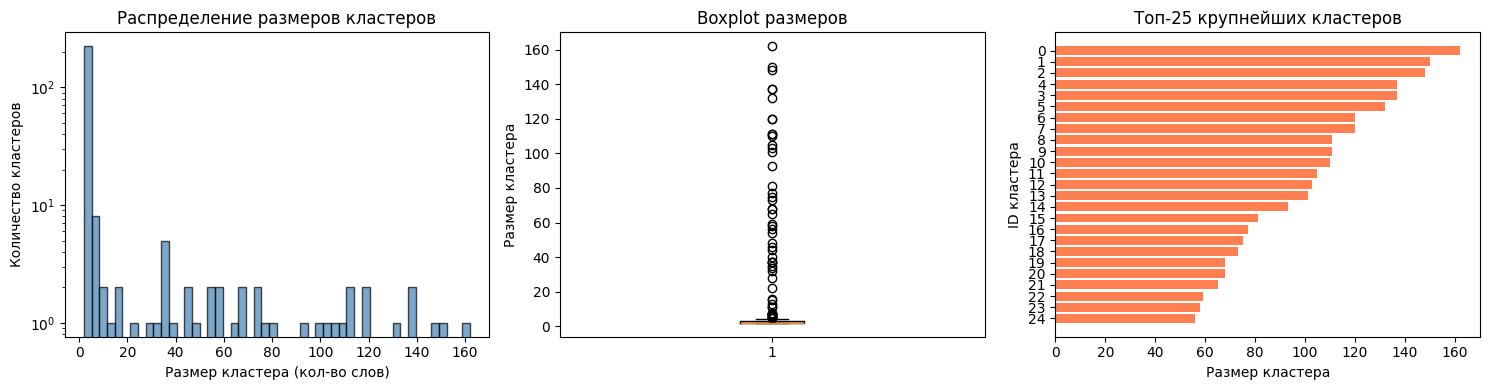

Всего кластеров: 274
Медианный размер: 2
Средний размер: 13.3
Макс размер: 162, Мин размер: 2


In [5]:
# 1. Распределение размеров кластеров
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Гистограмма размеров
ax = axes[0]
sizes = clusters_df["size"].values
ax.hist(sizes, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
ax.set_xlabel("Размер кластера (кол-во слов)")
ax.set_ylabel("Количество кластеров")
ax.set_title("Распределение размеров кластеров")
ax.set_yscale("log")

# Boxplot
ax = axes[1]
ax.boxplot(sizes, vert=True)
ax.set_ylabel("Размер кластера")
ax.set_title("Boxplot размеров")

# Top-N крупнейших кластеров (bar chart)
ax = axes[2]
top_n = 25
top_clusters = clusters_df.head(top_n)
ax.barh(top_clusters["cluster"].astype(str), top_clusters["size"], color="coral")
ax.set_xlabel("Размер кластера")
ax.set_ylabel("ID кластера")
ax.set_title(f"Топ-{top_n} крупнейших кластеров")
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Статистика
print(f"Всего кластеров: {len(clusters_df)}")
print(f"Медианный размер: {np.median(sizes):.0f}")
print(f"Средний размер: {np.mean(sizes):.1f}")
print(f"Макс размер: {np.max(sizes)}, Мин размер: {np.min(sizes)}")

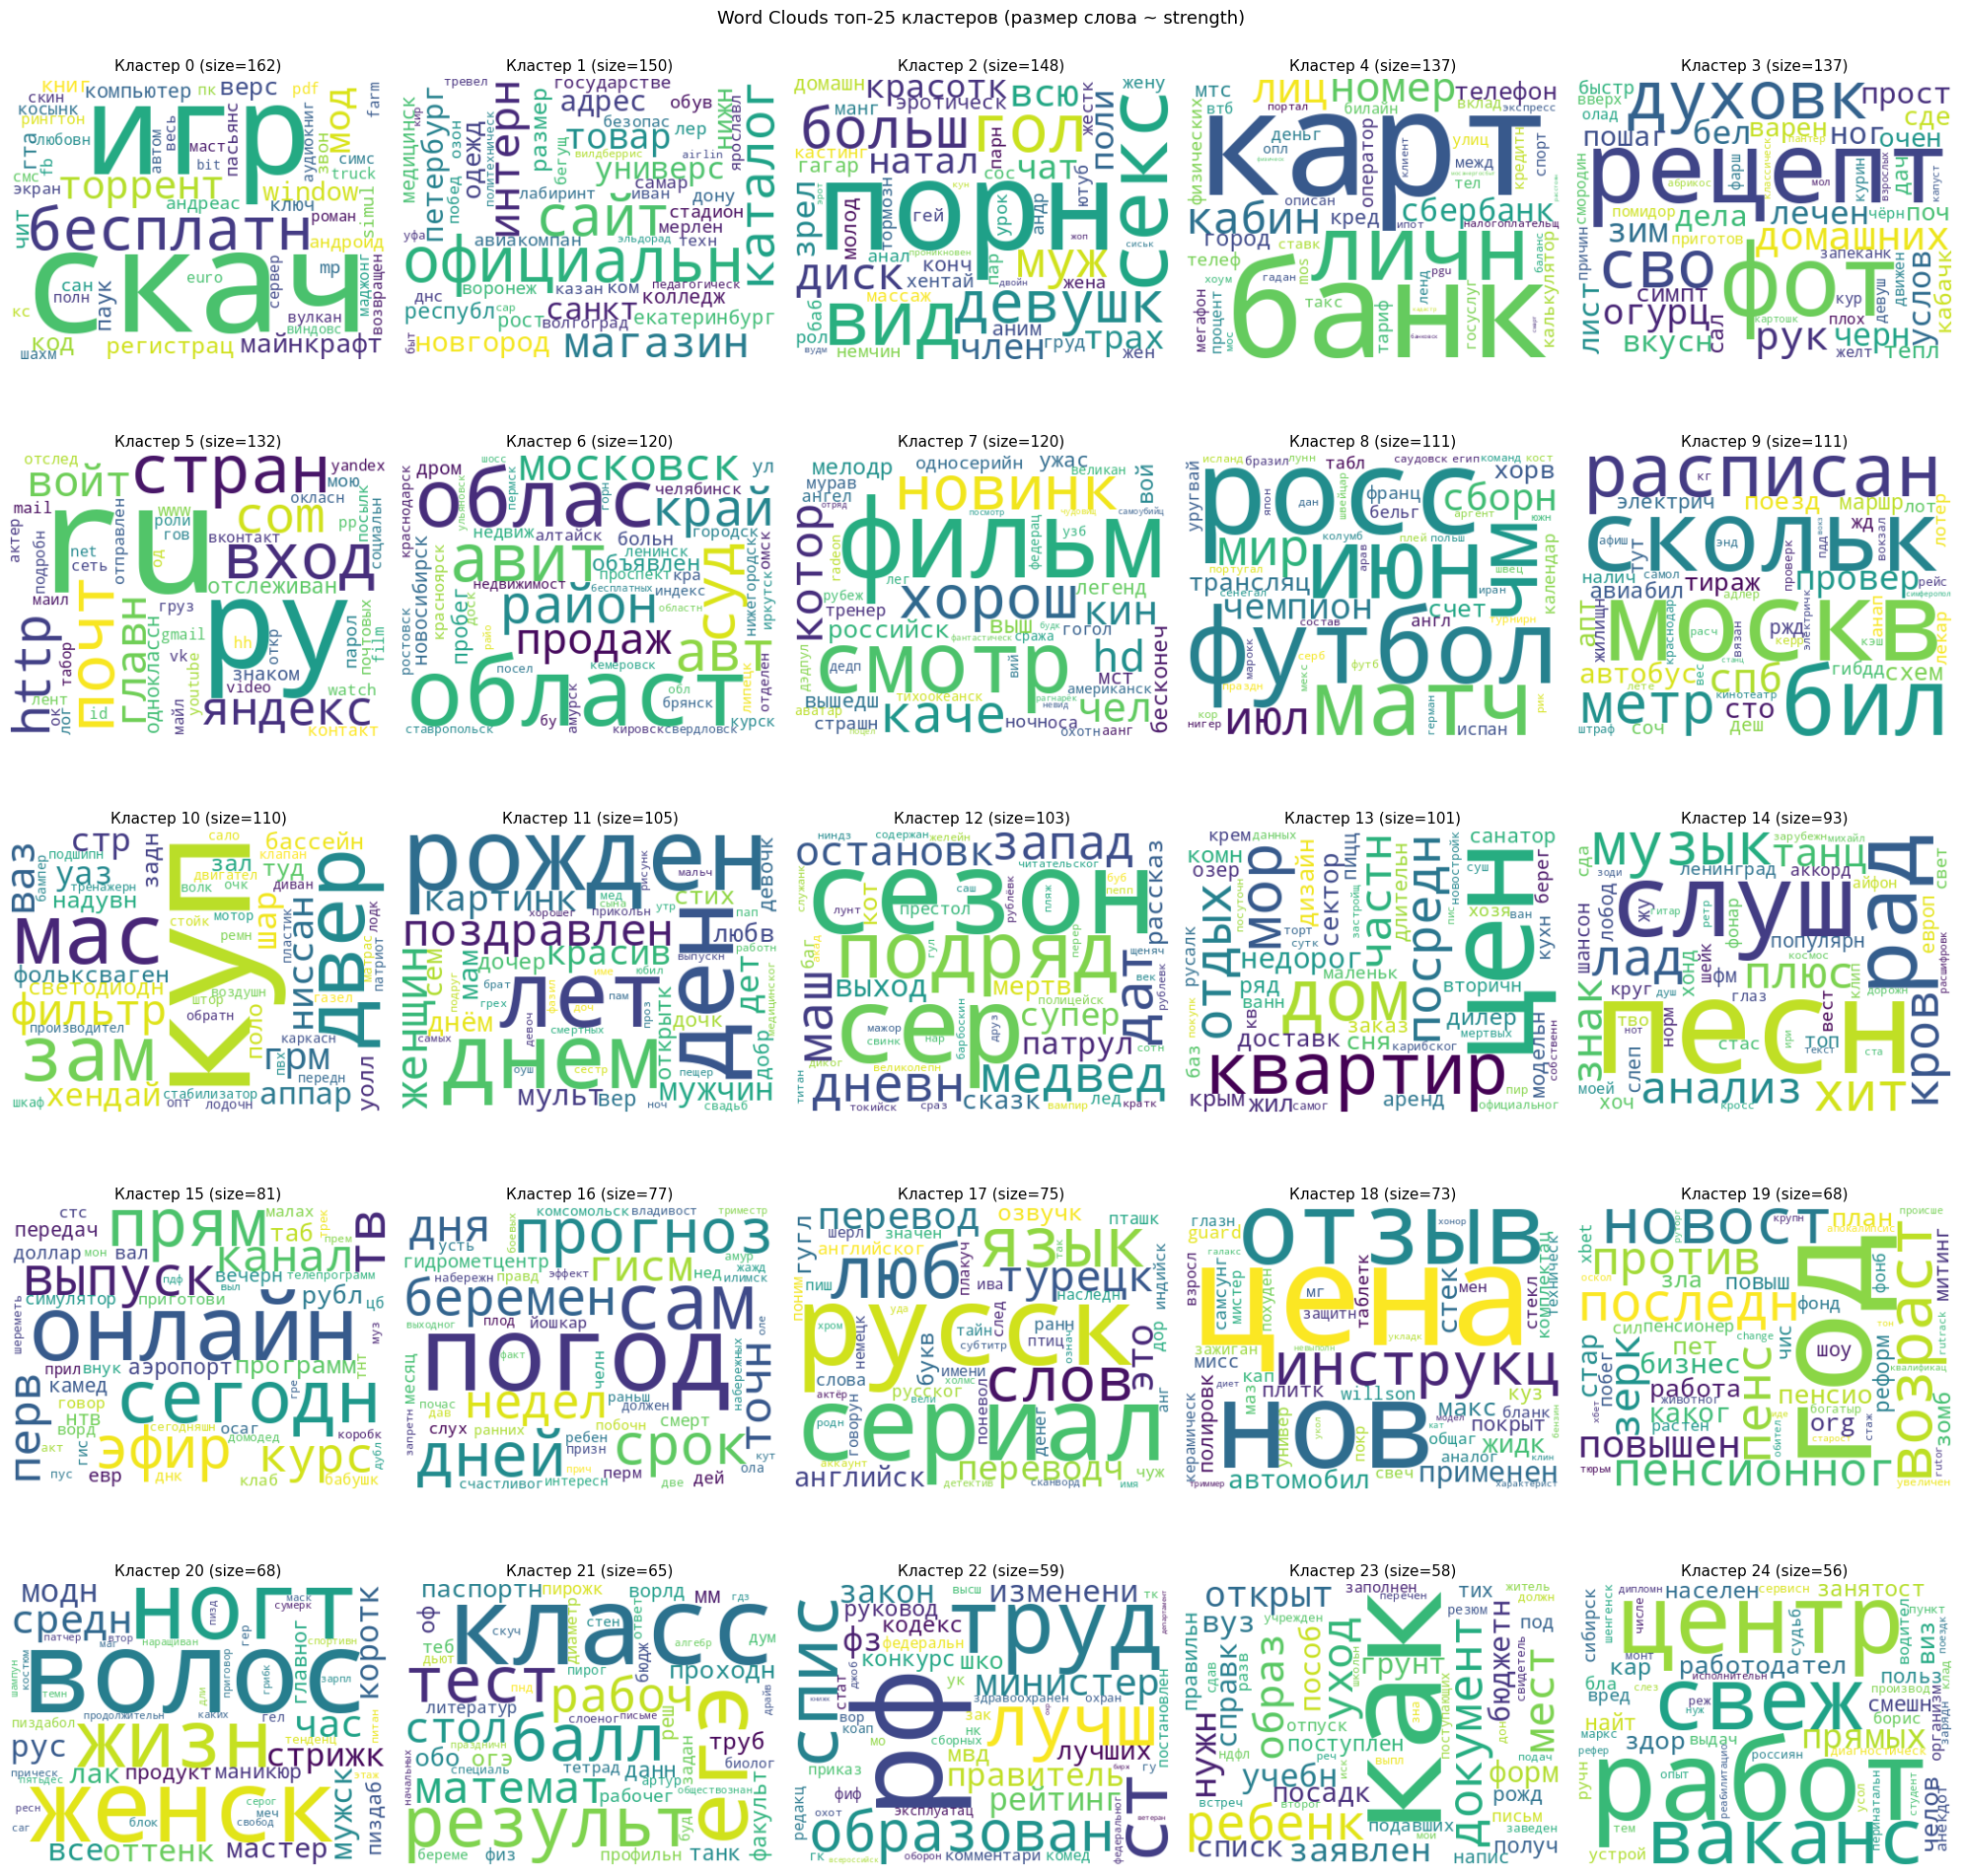

In [6]:
# 2. Word Clouds для топ-кластеров
from wordcloud import WordCloud

def make_cluster_wordcloud(cluster_id, partition, node_strength, ax, max_words=50):
    """Генерирует облако слов для кластера, размер слова ~ его strength в графе."""
    words = {n: max(node_strength.get(n, 0.01), 0.01) 
             for n, c in partition.items() if c == cluster_id}
    
    if not words:
        ax.text(0.5, 0.5, "Пустой кластер", ha="center", va="center")
        ax.axis("off")
        return
    
    wc = WordCloud(
        width=400, height=300,
        background_color="white",
        max_words=max_words,
        colormap="viridis",
        prefer_horizontal=0.7,
    ).generate_from_frequencies(words)
    
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Кластер {cluster_id} (size={len(words)})", fontsize=11)
    ax.axis("off")


# Визуализируем топ-25 кластеров
top_cluster_ids = clusters_df["cluster"].head(25).tolist()

fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

for ax, cid in zip(axes, top_cluster_ids):
    make_cluster_wordcloud(cid, partition_leiden, node_strength, ax)

plt.suptitle("Word Clouds топ-25 кластеров (размер слова ~ strength)", fontsize=13)
plt.tight_layout()
plt.show()

Взят подграф: 1000 узлов, 4997 рёбер


/var/folders/lw/f0n2qlq93lbgl6jfwf_6z7980000gn/T/ipykernel_30491/2050274429.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_clusters))


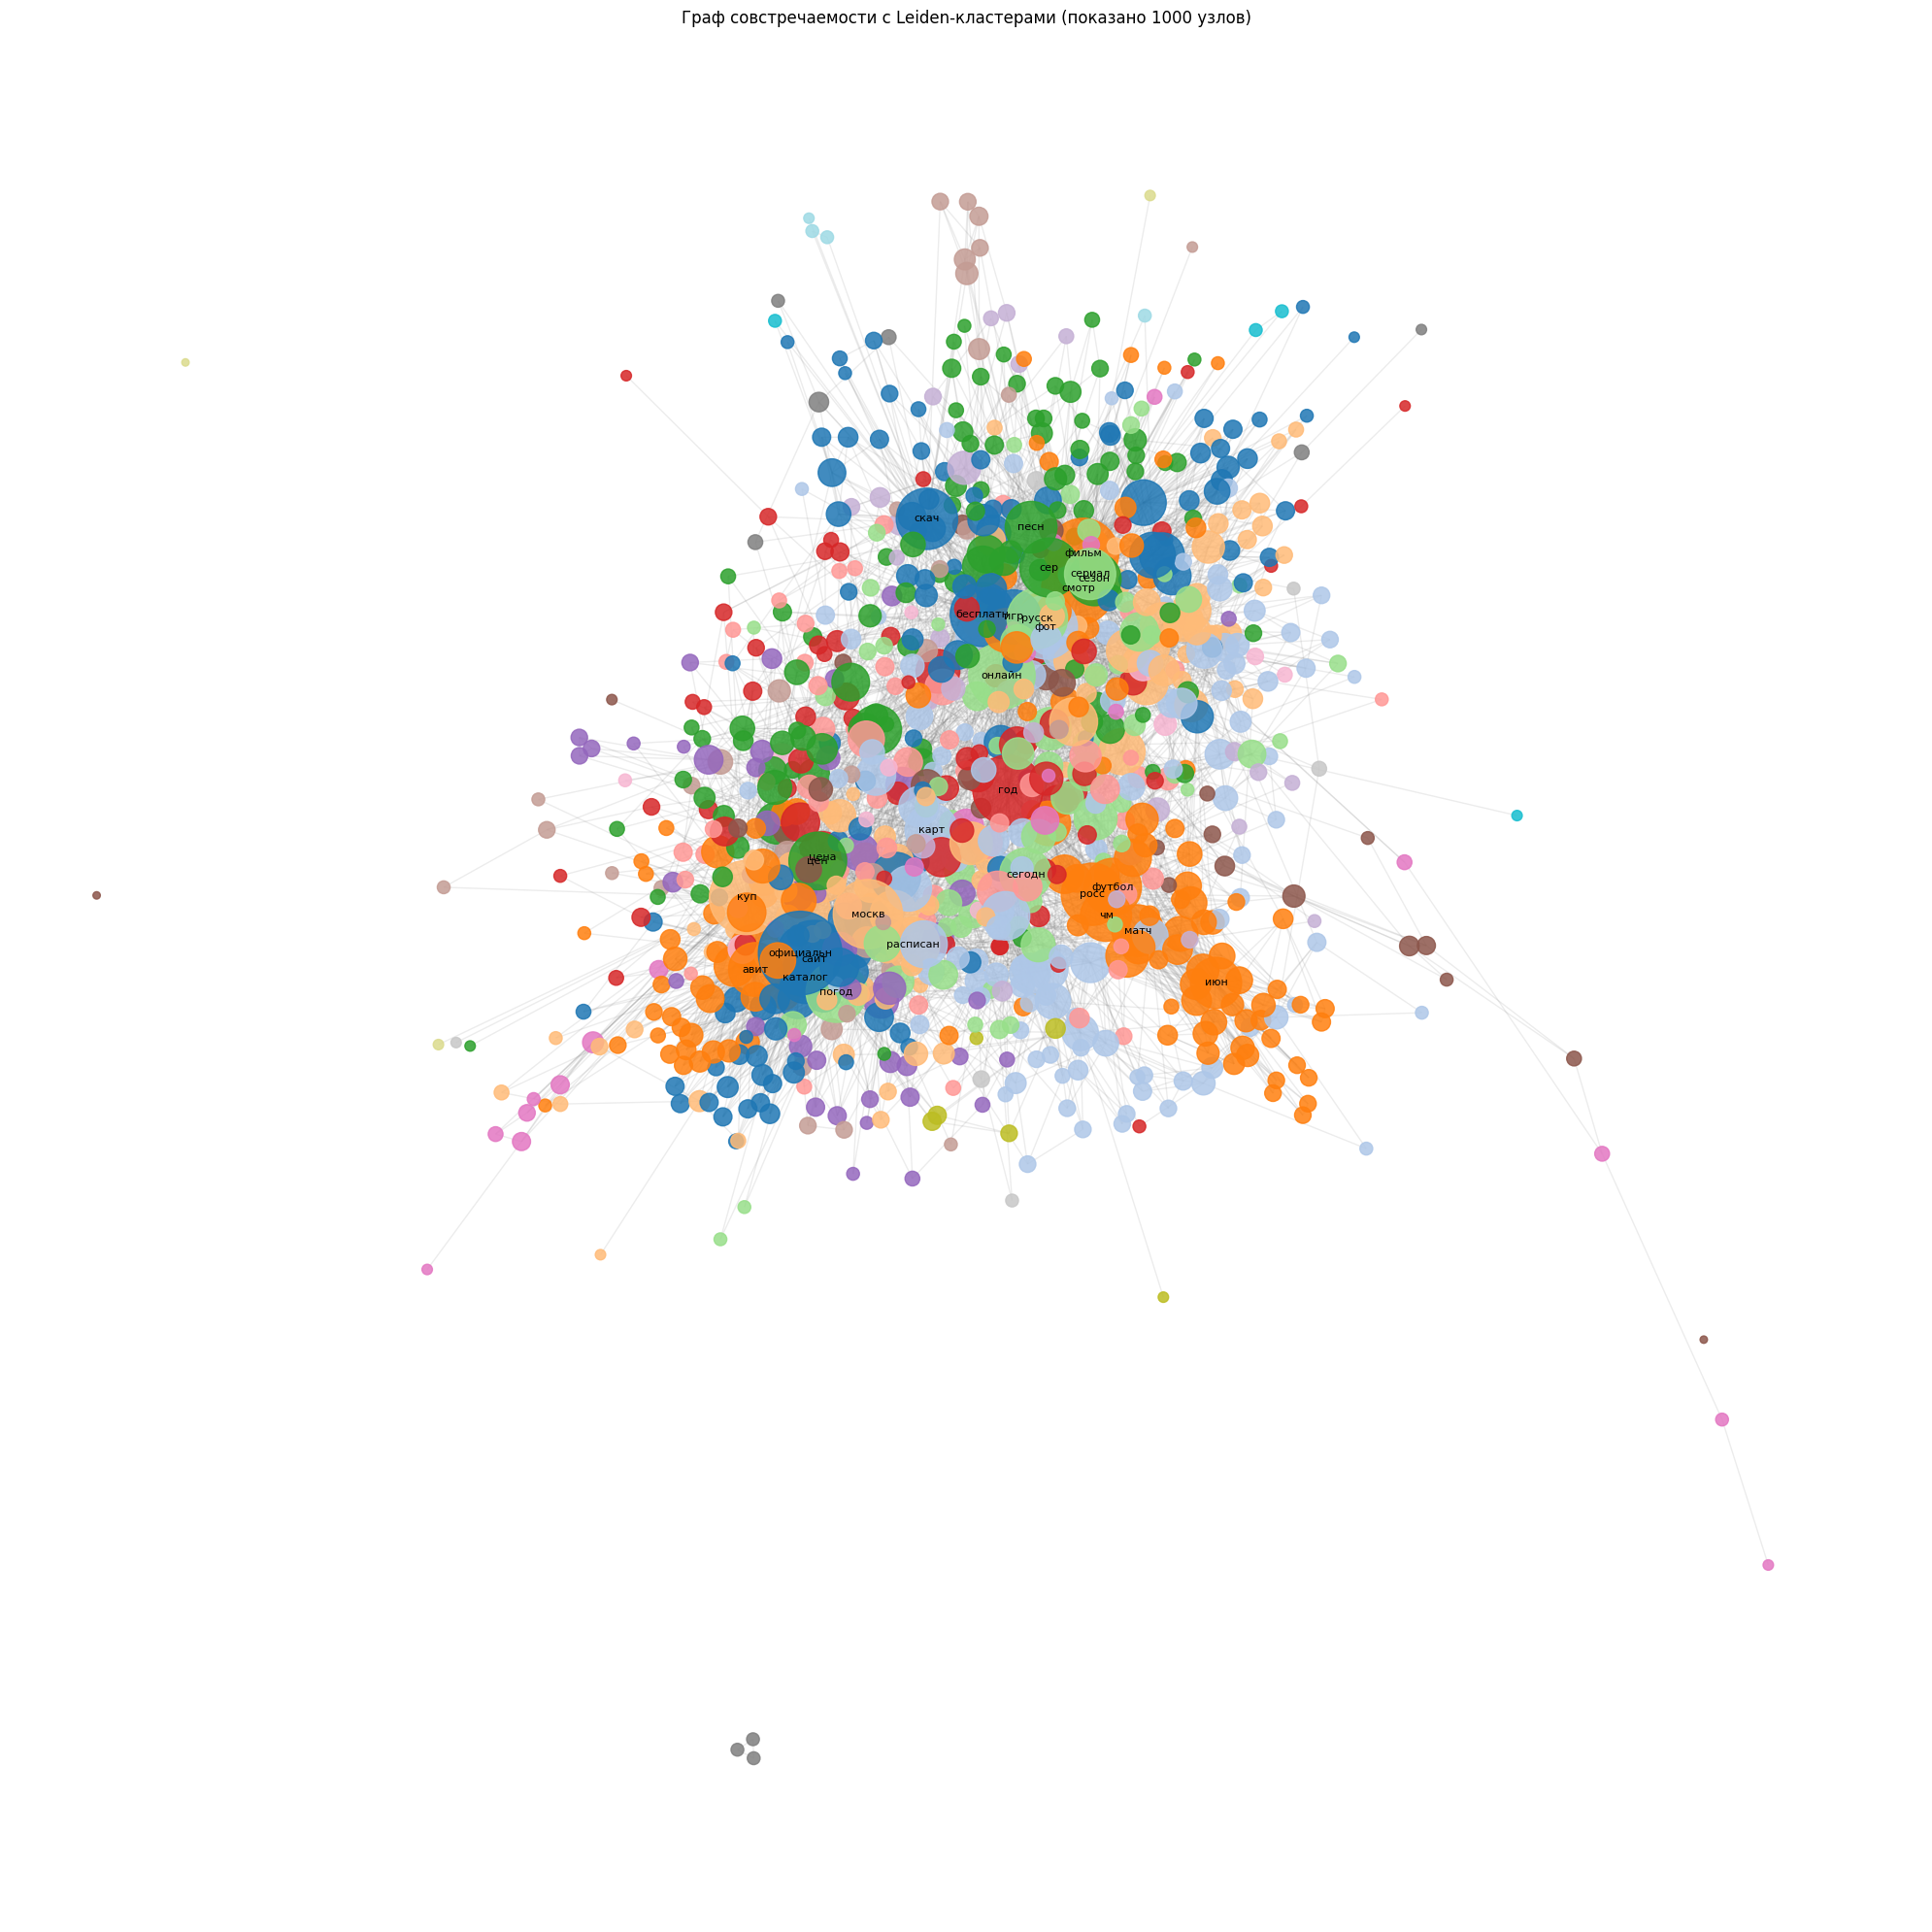

In [25]:
# 3. Статичная визуализация графа с подсветкой кластеров (matplotlib)
# Для больших графов используем подвыборку или backbone

def visualize_graph_clusters(
    G, 
    partition, 
    max_nodes=500,
    node_size_factor=30,
    edge_alpha=0.15,
    figsize=(20, 20),
    seed=42
):
    """Визуализация графа с цветовой раскраской по кластерам."""
    
    # Если граф слишком большой — берём подграф на топ-узлах по degree
    if G.number_of_nodes() > max_nodes:
        top_nodes = sorted(G.nodes(), key=lambda n: G.degree(n), reverse=True)[:max_nodes]
        G_sub = G.subgraph(top_nodes).copy()
        print(f"Взят подграф: {G_sub.number_of_nodes()} узлов, {G_sub.number_of_edges()} рёбер")
    else:
        G_sub = G
    
    # Цвета кластеров
    unique_clusters = sorted(set(partition.get(n, -1) for n in G_sub.nodes()))
    cmap = plt.cm.get_cmap("tab20", len(unique_clusters))
    cluster_to_color = {c: cmap(i) for i, c in enumerate(unique_clusters)}
    
    node_colors = [cluster_to_color.get(partition.get(n, -1), (0.5, 0.5, 0.5, 1.0)) for n in G_sub.nodes()]
    node_sizes = [node_size_factor * (1 + G_sub.degree(n)) for n in G_sub.nodes()]
    
    # Layout
    pos = nx.spring_layout(G_sub, k=0.5, iterations=80, seed=seed)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Рёбра
    nx.draw_networkx_edges(G_sub, pos, alpha=edge_alpha, edge_color="gray", ax=ax)
    
    # Узлы
    nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=node_sizes, ax=ax, alpha=0.85)
    
    # Подписи только для топ-узлов
    top_degree_nodes = sorted(G_sub.nodes(), key=lambda n: G_sub.degree(n), reverse=True)[:30]
    labels = {n: n for n in top_degree_nodes}
    nx.draw_networkx_labels(G_sub, pos, labels, font_size=8, ax=ax)
    
    ax.set_title(f"Граф совстречаемости с Leiden-кластерами (показано {G_sub.number_of_nodes()} узлов)", fontsize=12)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


visualize_graph_clusters(G, partition_leiden, max_nodes=1000, seed=42)

In [27]:
# 4. Интерактивная визуализация с pyvis (откроется в браузере)
from pyvis.network import Network
import random

def interactive_graph_clusters(
    G, 
    partition, 
    node_strength,
    max_nodes=300,
    output_file="cluster_graph.html"
):
    """Интерактивный граф в браузере с pyvis."""
    
    # Подвыборка узлов
    if G.number_of_nodes() > max_nodes:
        top_nodes = sorted(G.nodes(), key=lambda n: G.degree(n), reverse=True)[:max_nodes]
        G_sub = G.subgraph(top_nodes).copy()
    else:
        G_sub = G
    
    # Генерация цветов для кластеров
    unique_clusters = sorted(set(partition.get(n, -1) for n in G_sub.nodes()))
    random.seed(42)
    cluster_colors = {
        c: f"#{random.randint(0, 0xFFFFFF):06x}" for c in unique_clusters
    }
    
    net = Network(height="800px", width="100%", bgcolor="#ffffff", font_color="black")
    net.barnes_hut(gravity=-5000, central_gravity=0.3, spring_length=100)
    
    # Добавляем узлы
    for node in G_sub.nodes():
        cluster = partition.get(node, -1)
        strength = node_strength.get(node, 1.0)
        size = 10 + min(strength * 3, 50)  # масштабируем размер
        color = cluster_colors.get(cluster, "#888888")
        
        net.add_node(
            node, 
            label=node, 
            title=f"{node}\nКластер: {cluster}\nStrength: {strength:.2f}\nDegree: {G_sub.degree(node)}",
            size=size,
            color=color
        )
    
    # Добавляем рёбра
    for u, v, d in G_sub.edges(data=True):
        weight = d.get("weight", 1.0)
        net.add_edge(u, v, value=max(weight * 2, 0.5), title=f"weight: {weight:.3f}")

    net.save_graph(output_file)
    print(f"✓ Интерактивный граф сохранён: {output_file}")
    print(f"  Узлов: {G_sub.number_of_nodes()}, Рёбер: {G_sub.number_of_edges()}")
    return output_file


# Генерируем интерактивный граф
html_file = interactive_graph_clusters(G, partition_leiden, node_strength, max_nodes=1000)

✓ Интерактивный граф сохранён: cluster_graph.html
  Узлов: 1000, Рёбер: 4997


Отобрано 2520 узлов из топ-25 кластеров


/var/folders/lw/f0n2qlq93lbgl6jfwf_6z7980000gn/T/ipykernel_30491/1490024289.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_clusters))


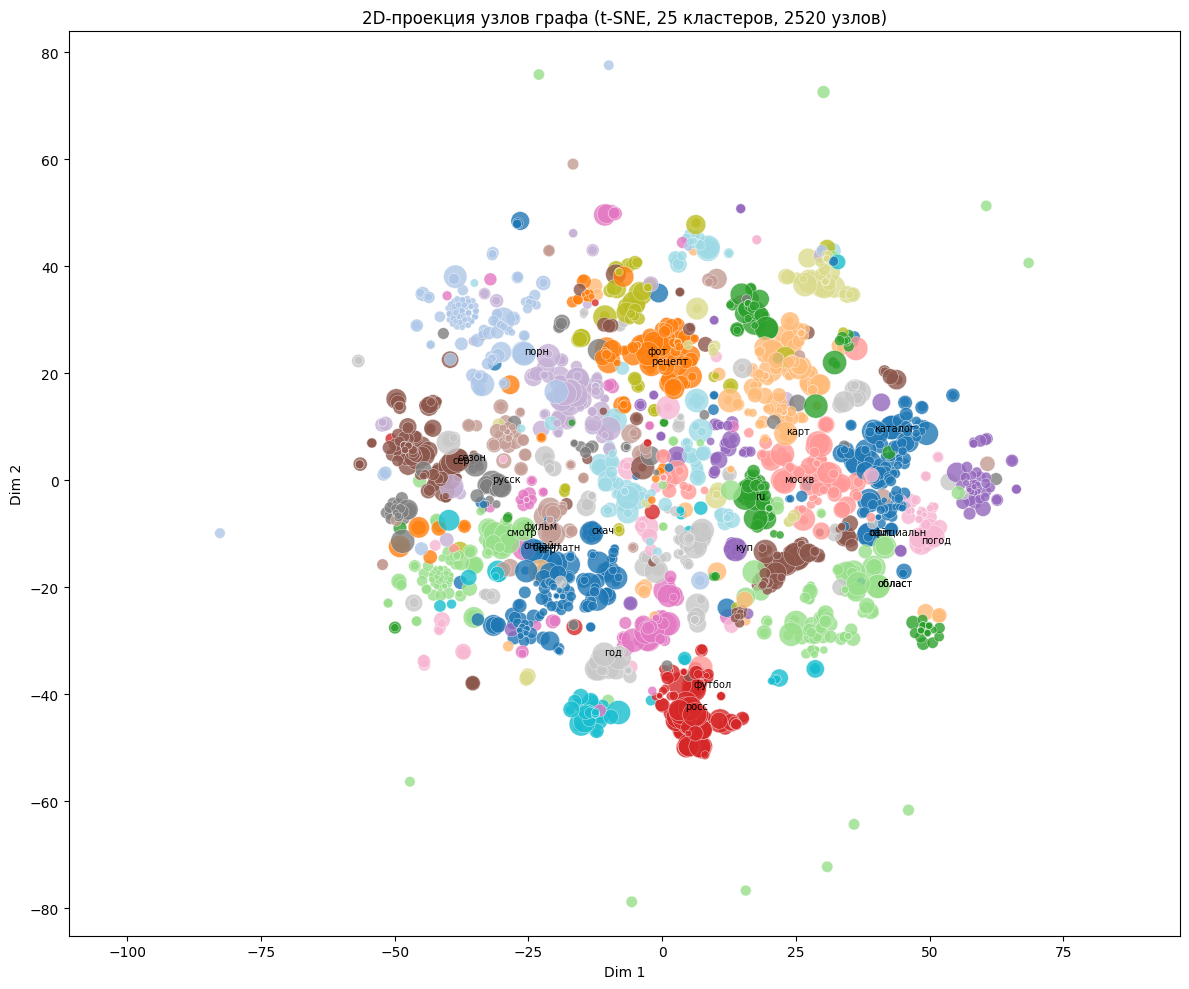

In [26]:
# 5. 2D-проекция вершин через t-SNE (node embeddings из adjacency)
from sklearn.manifold import TSNE

def node_embeddings_2d(G, partition, method="tsne", n_components=2, top_n_clusters=None, seed=42):
    """Проецируем узлы графа в 2D на основе adjacency matrix.
    
    Параметры:
    - top_n_clusters: если задано, берём только узлы из топ-N крупнейших кластеров
    """
    
    # Фильтруем узлы по топ-кластерам
    if top_n_clusters is not None:
        cluster_sizes = pd.Series(partition).value_counts()
        top_clusters = set(cluster_sizes.head(top_n_clusters).index)
        nodes = [n for n in G.nodes() if partition.get(n, -1) in top_clusters]
        print(f"Отобрано {len(nodes)} узлов из топ-{top_n_clusters} кластеров")
    else:
        nodes = list(G.nodes())
    
    if len(nodes) < 2:
        raise ValueError("Недостаточно узлов для проекции")
    
    # Подграф только на отобранных узлах
    G_sub = G.subgraph(nodes)
    
    # Adjacency matrix
    A = nx.to_scipy_sparse_array(G_sub, nodelist=nodes, weight="weight", format="csr")
    A = A.astype(np.float32)
    
    # Нормализуем строки (row-wise L2 norm) для лучшего embedding
    from sklearn.preprocessing import normalize
    A_norm = normalize(A, norm="l2", axis=1)
    
    if method == "tsne":
        reducer = TSNE(
            n_components=n_components, 
            perplexity=min(30, len(nodes) - 1),
            metric="cosine",
            init="random",
            random_state=seed,
            n_jobs=-1
        )
        coords = reducer.fit_transform(A_norm.toarray())
    else:
        # UMAP (если установлен)
        try:
            import umap
            reducer = umap.UMAP(
                n_components=n_components,
                metric="cosine",
                n_neighbors=15,
                min_dist=0.1,
                random_state=seed
            )
            coords = reducer.fit_transform(A_norm.toarray())
        except ImportError:
            print("UMAP не установлен, используем t-SNE")
            return node_embeddings_2d(G, partition, method="tsne", top_n_clusters=top_n_clusters, seed=seed)
    
    return nodes, coords


def plot_node_embeddings(nodes, coords, partition, node_strength, figsize=(12, 10), top_labels=25):
    """Scatter plot 2D-эмбеддингов с раскраской по кластерам."""
    
    clusters = np.array([partition.get(n, -1) for n in nodes])
    strengths = np.array([node_strength.get(n, 1.0) for n in nodes])
    
    unique_clusters = sorted(set(clusters))
    cmap = plt.cm.get_cmap("tab20", len(unique_clusters))
    cluster_to_idx = {c: i for i, c in enumerate(unique_clusters)}
    colors = [cmap(cluster_to_idx[c]) for c in clusters]
    
    # Размер точки ~ strength
    sizes = 10 + strengths * 50
    sizes = np.clip(sizes, 10, 300)
    
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(coords[:, 0], coords[:, 1], c=colors, s=sizes, alpha=0.8, edgecolors="white", linewidths=0.3)
    
    # Подписи для топ-узлов
    top_indices = np.argsort(strengths)[-top_labels:]
    for idx in top_indices:
        ax.annotate(nodes[idx], (coords[idx, 0], coords[idx, 1]), fontsize=7, alpha=1)
    
    n_clusters = len(unique_clusters)
    ax.set_title(f"2D-проекция узлов графа (t-SNE, {n_clusters} кластеров, {len(nodes)} узлов)", fontsize=12)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.axis("equal")
    plt.tight_layout()
    plt.show()


# Строим 2D-проекцию только для топ-10 кластеров
nodes_list, coords_2d = node_embeddings_2d(
    G, partition_leiden, 
    method="tsne", 
    top_n_clusters=25,  # None = все кластеры
    seed=42
)
plot_node_embeddings(nodes_list, coords_2d, partition_leiden, node_strength)

In [10]:
# 6. Таблица с характеристиками топ-кластеров (сводка)

def cluster_summary_table(partition, node_strength, edges_df, top_n=15):
    """Создаёт информативную сводку по кластерам."""
    
    # Группируем узлы по кластерам
    cluster_nodes = {}
    for node, cid in partition.items():
        cluster_nodes.setdefault(cid, []).append(node)
    
    rows = []
    for cid, nodes in cluster_nodes.items():
        strengths = [node_strength.get(n, 0.0) for n in nodes]
        top_words = sorted(nodes, key=lambda n: node_strength.get(n, 0), reverse=True)[:5]
        
        rows.append({
            "cluster": cid,
            "size": len(nodes),
            "total_strength": sum(strengths),
            "avg_strength": np.mean(strengths) if strengths else 0,
            "top_words": ", ".join(top_words),
        })
    
    summary_df = pd.DataFrame(rows).sort_values("size", ascending=False).reset_index(drop=True)
    
    # Добавляем intra-cluster edges из edges_df
    src_c = edges_df["src"].map(partition)
    dst_c = edges_df["dst"].map(partition)
    intra_mask = src_c == dst_c
    
    intra_stats = (
        edges_df[intra_mask]
        .assign(cluster=src_c[intra_mask])
        .groupby("cluster")
        .agg(intra_edges=("weight", "size"), intra_weight=("weight", "sum"))
        .reset_index()
    )
    
    summary_df = summary_df.merge(intra_stats, on="cluster", how="left").fillna(0)
    summary_df["density"] = summary_df["intra_edges"] / (summary_df["size"] * (summary_df["size"] - 1) / 2 + 1e-9)
    
    return summary_df.head(top_n)


summary = cluster_summary_table(partition_leiden, node_strength, edges_df, top_n=25)

# Красивый вывод
from IPython.display import display
display(summary.style.format({
    "total_strength": "{:.1f}",
    "avg_strength": "{:.3f}",
    "intra_weight": "{:.1f}",
    "density": "{:.4f}"
}).background_gradient(subset=["size", "total_strength", "density"], cmap="Blues"))

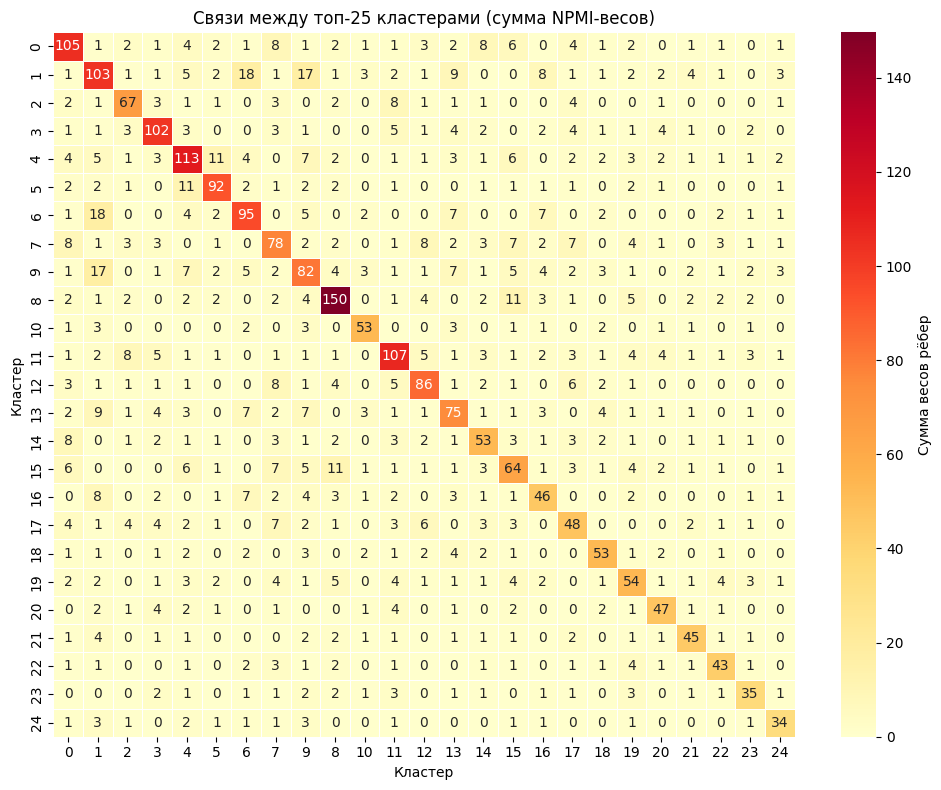

In [11]:
# 7. Heatmap: матрица связей между топ-кластерами (inter-cluster edges)

def inter_cluster_heatmap(edges_df, partition, top_n_clusters=12):
    """Строит heatmap связей между крупнейшими кластерами."""
    
    # Определяем топ-кластеры по размеру
    cluster_sizes = pd.Series(partition).value_counts()
    top_clusters = cluster_sizes.head(top_n_clusters).index.tolist()
    
    src_c = edges_df["src"].map(partition)
    dst_c = edges_df["dst"].map(partition)
    
    # Только рёбра между топ-кластерами
    mask = src_c.isin(top_clusters) & dst_c.isin(top_clusters)
    df_filtered = edges_df[mask].copy()
    df_filtered["src_c"] = src_c[mask]
    df_filtered["dst_c"] = dst_c[mask]
    
    # Агрегируем веса
    agg = df_filtered.groupby(["src_c", "dst_c"])["weight"].sum().reset_index()
    
    # Строим симметричную матрицу
    matrix = pd.DataFrame(0.0, index=top_clusters, columns=top_clusters)
    for _, row in agg.iterrows():
        matrix.loc[row["src_c"], row["dst_c"]] += row["weight"]
        if row["src_c"] != row["dst_c"]:
            matrix.loc[row["dst_c"], row["src_c"]] += row["weight"]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        matrix, 
        annot=True, 
        fmt=".0f", 
        cmap="YlOrRd", 
        linewidths=0.5,
        ax=ax,
        cbar_kws={"label": "Сумма весов рёбер"}
    )
    ax.set_title(f"Связи между топ-{top_n_clusters} кластерами (сумма NPMI-весов)")
    ax.set_xlabel("Кластер")
    ax.set_ylabel("Кластер")
    plt.tight_layout()
    plt.show()


inter_cluster_heatmap(edges_df, partition_leiden, top_n_clusters=25)